In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from model import load_data, load_config
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

In [2]:
config_file = "config_3a_only.yml"
clf = LogisticRegression(solver="lbfgs", multi_class="auto")

In [3]:
steps = [
    ("logscale", FunctionTransformer(np.log1p, validate=True)),
    ("normalize", StandardScaler()),
    ("clf", clf),
]

In [4]:
classifier = Pipeline(steps=steps)

In [5]:
config = load_config(config_file)
config["SELECTOR"] = "../output/20191127_p186_3A_Only_selector.joblib"
config["PERMTEST"] = "../output/20191130_p186_3A_Only_permtest.joblib"
selectors = joblib.load(config["SELECTOR"])
permtest = joblib.load(config["PERMTEST"])
X, y = load_data(config["MAIN"], config_file=config_file)

In [6]:
splits = selectors.pop()

In [7]:
eval_dict = {"split": [], "fsize": [], "idx": [], "metric": [], "value": []}
for i, (split, selector) in enumerate(zip(splits, selectors)):
    X_train = X.iloc[split[0], :].copy()
    X_test = X.iloc[split[1], :].copy()
    y_train = y.iloc[split[0]].copy()
    y_test = y.iloc[split[1]].copy()
    for fsize in range(1, 11):
        fidx = list(selector[-1].get_metric_dict()[fsize]["feature_idx"])
        # append average train value
        eval_dict["split"].append(i + 1)
        eval_dict["fsize"].append(fsize)
        eval_dict["idx"].append(fidx)
        eval_dict["metric"].append("avg_train")
        eval_dict["value"].append(selector[-1].get_metric_dict()[fsize]["avg_score"])
        # append individual train folds
        for val in selector[-1].get_metric_dict()[fsize]["cv_scores"]:
            eval_dict["metric"].append("train")
            eval_dict["value"].append(val)
            eval_dict["split"].append(i + 1)
            eval_dict["fsize"].append(fsize)
            eval_dict["idx"].append(fidx)
        # get test predictions
        classifier.fit(X_train.iloc[:, fidx], y_train)
        y_pred = classifier.predict(X_test.iloc[:, fidx])
        test_acc = accuracy_score(y_test, y_pred)
        eval_dict["split"].append(i + 1)
        eval_dict["fsize"].append(fsize)
        eval_dict["idx"].append(fidx)
        eval_dict["metric"].append("test")
        eval_dict["value"].append(test_acc)

In [8]:
df = pd.DataFrame(eval_dict)

In [9]:
df_long = df.melt(id_vars=["split", "fsize", "idx"], var_name="metric")

In [11]:
df_all = df.loc[df["metric"] != "avg_train"]

Text(0.5, 1.0, 'Accuracy vs Number of Features')

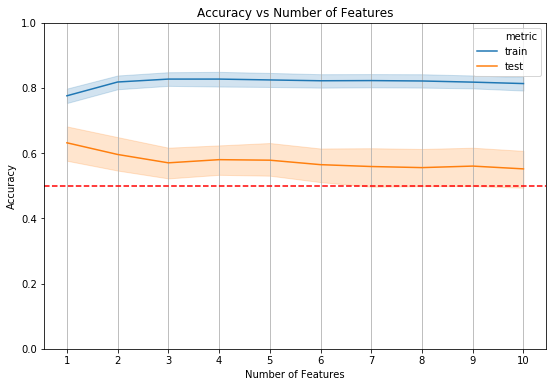

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.lineplot(x="fsize", y="value", hue="metric", data=df_all)
plt.xticks(np.arange(1, 11))
plt.ylim([0, 1])
plt.axhline(0.5, color="r", linestyle="--")
plt.grid(True, axis="x")
plt.ylabel("Accuracy")
plt.xlabel("Number of Features")
plt.title("Accuracy vs Number of Features")

Text(0.5, 1, 'Accuracy vs Number of Features')

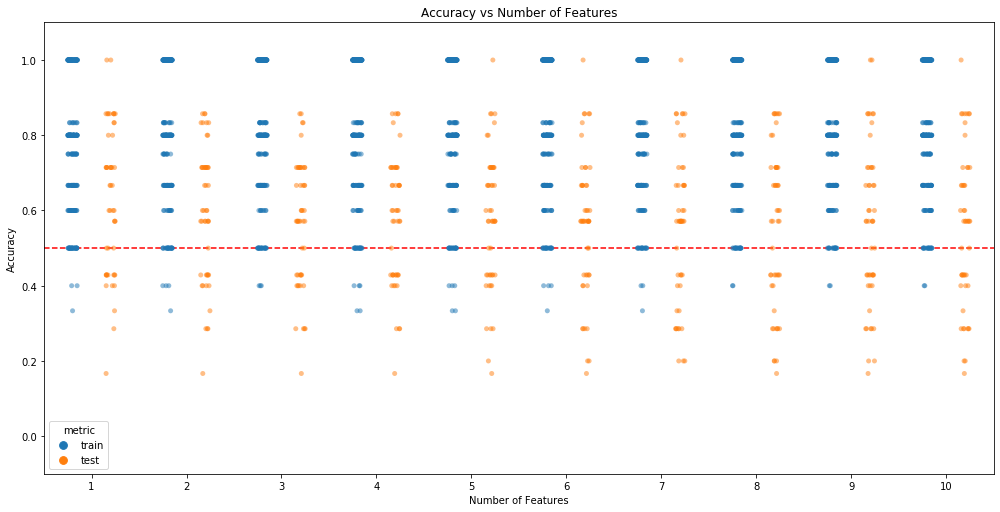

In [13]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.stripplot(
    x="fsize", y="value", hue="metric", data=df_all, dodge=True, size=5, alpha=0.5
)
# plt.xticks(np.arange(1,11))
plt.ylim([-0.1, 1.1])
plt.axhline(0.5, color="r", linestyle="--")
plt.ylabel("Accuracy")
plt.xlabel("Number of Features")
plt.tight_layout()
plt.title("Accuracy vs Number of Features")

In [71]:
df.loc[df["fsize"] == 1]["idx"].value_counts()

[47]    19
[24]    10
[51]     6
[39]     5
[34]     2
[43]     2
[49]     2
[28]     1
[8]      1
[37]     1
[26]     1
Name: idx, dtype: int64

Text(0.5, 1, 'Accuracy vs Number of Features')

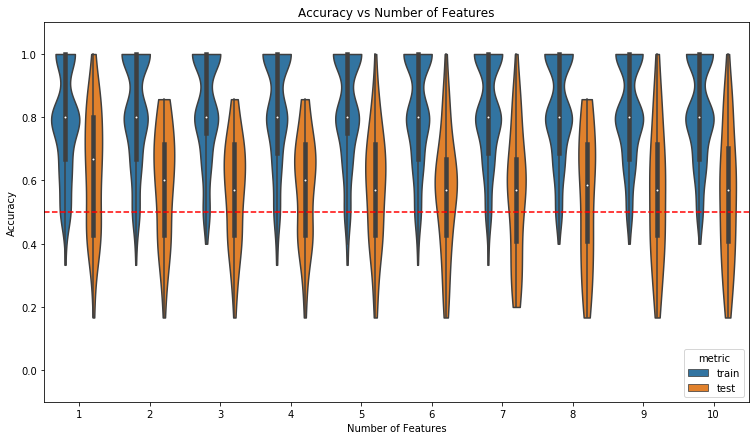

In [14]:
fig, ax = plt.subplots(figsize=(10.6, 6))
sns.violinplot(x="fsize", y="value", hue="metric", data=df_all, cut=0)
# plt.xticks(np.arange(1,11))
plt.ylim([-0.1, 1.1])
plt.axhline(0.5, color="r", linestyle="--")
plt.ylabel("Accuracy")
plt.xlabel("Number of Features")
plt.tight_layout()
plt.title("Accuracy vs Number of Features")

In [18]:
permtest[1]['data'].keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test'])

In [21]:
permtest[1]['selectors']

[Pipeline(memory=None,
          steps=[('logscale',
                  FunctionTransformer(accept_sparse=False, check_inverse=True,
                                      func=<ufunc 'log1p'>, inv_kw_args=None,
                                      inverse_func=None, kw_args=None,
                                      pass_y='deprecated', validate=True)),
                 ('normalize',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('sffs',
                  SequentialFeatureSelector(clone_estimator=True, cv=5,
                                            estimator=LogisticRegression(C=1.0,
                                                                         class_weight=None,
                                                                         dual=False,
                                                                         fit_intercept=True,
                                                                         intercept_scal

In [ ]:
permtest

In [ ]:
for run in permtest:
    X_train = run['data']['X_train']
    y_train = run['data']['y_train']
    X_test = run['data']['X_test']
    y_test = run['data']['y_test']
    cv_temp = run['cv']
    selectors_temp = run['selectors']